In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime
import matplotlib.pyplot as plt   
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

In [2]:
INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_main_new'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select "EM_TOTAL_Import_Energy(kWh)", "DeviceID", "time" from ' + TARGET_MEASUREMENT + ' where time > now() - 24d '
data = pd.DataFrame(con_obj.query(query).get_points())
data['time'] = data['time'].astype('datetime64[ns]')

In [3]:
date_old = (pd.datetime.now().date() - pd.offsets.Day(23))
date_now = pd.datetime.now().date() - pd.offsets.Day(0)
df2 = data[(data['time'] >= date_old) & (data['time'] < date_now)]
df2 = df2[['time', 'EM_TOTAL_Import_Energy(kWh)','DeviceID']]

In [4]:
df3 = df2.copy()
df3 = df3.set_index("time")
print(df3.index.min())
print(df3.index.max())

2020-06-15 01:04:19.266746880
2020-07-06 23:59:59.756305920


In [6]:
class half_an_hour_min_energy:  
    
    def difference(self,df2):
        diff = []
        for g,i in df2.groupby(pd.Grouper(freq ='H',key ='time'))['EM_TOTAL_Import_Energy(kWh)']:
            try:
                diff.append([g,i.iloc[-1]-i.iloc[0]])
            except:
                diff.append([g,np.nan])
        x=pd.DataFrame(diff)
        return x        
                
    def output(self, df2):
            y = df2.groupby('DeviceID').apply(self.difference)
            y = y.pivot_table(index = 0,columns ='DeviceID',values = 1).reset_index()
            y.columns.name = None
            y = y.rename(columns = {0: ""})
            y = y.set_index("")
            y = y.fillna(0)
            return y

In [7]:
cat = half_an_hour_min_energy()
df4 = cat.output(df2)
df4.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
,,,,,,,,,,,,
2020-06-15 01:00:00,995.0,38.8,0.0,3.6,0.0,0.0,363.0,272.0,0.6,0.0,80.2,49.3
2020-06-15 02:00:00,76.0,2.9,0.0,0.3,0.0,0.0,19.0,25.0,0.1,0.0,6.1,3.4
2020-06-15 04:00:00,1067.0,40.5,0.0,2.7,15.6,0.0,270.0,313.0,0.8,0.0,68.8,48.0
2020-06-15 05:00:00,1208.0,47.5,0.0,3.8,24.7,0.0,250.0,337.0,0.4,0.1,79.8,57.4
2020-06-15 06:00:00,1260.0,47.2,0.0,3.8,41.2,0.0,293.0,384.0,0.0,0.1,79.3,55.0


In [9]:
Time_range = pd.DataFrame(pd.date_range(start = '2020-06-15 00:00:00', end = '2020-07-07 00:00:00', freq = 'H'))
Time_range = Time_range.rename(columns = {0 : "time"})
Time_range.set_index("time", inplace = True)
# Time_range.tail()

In [11]:
data = df4.copy()

In [12]:
data = data.merge(Time_range,  how = "outer", right_index=True, left_index=True)
data.index.freq = 'H'

In [13]:
data.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
2020-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15 01:00:00,995.0,38.8,0.0,3.6,0.0,0.0,363.0,272.0,0.6,0.0,80.2,49.3
2020-06-15 02:00:00,76.0,2.9,0.0,0.3,0.0,0.0,19.0,25.0,0.1,0.0,6.1,3.4
2020-06-15 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15 04:00:00,1067.0,40.5,0.0,2.7,15.6,0.0,270.0,313.0,0.8,0.0,68.8,48.0


In [14]:
data.tail()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
2020-07-06 20:00:00,665.0,33.9,0.0,0.0,43.8,0.0,76.0,306.0,0.0,0.0,0.0,38.7
2020-07-06 21:00:00,619.0,39.1,0.0,0.0,43.7,0.0,75.0,247.0,0.0,0.1,0.0,31.1
2020-07-06 22:00:00,621.0,38.9,0.0,0.0,43.7,0.0,66.0,258.0,0.0,0.0,0.0,25.0
2020-07-06 23:00:00,644.0,38.9,0.0,0.0,43.7,0.0,76.0,266.0,0.0,0.0,0.0,32.7
2020-07-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
EM4 = data[["EM4"]]

In [16]:
EM4 = EM4.iloc[:-1]

In [17]:
EM4_filled = EM4.fillna(method = "ffill")

In [18]:
EM4_filled.iloc[0] = EM4_filled.iloc[1]
EM4_filled.head()

,EM4
2020-06-15 00:00:00,363.0
2020-06-15 01:00:00,363.0
2020-06-15 02:00:00,19.0
2020-06-15 03:00:00,19.0
2020-06-15 04:00:00,270.0


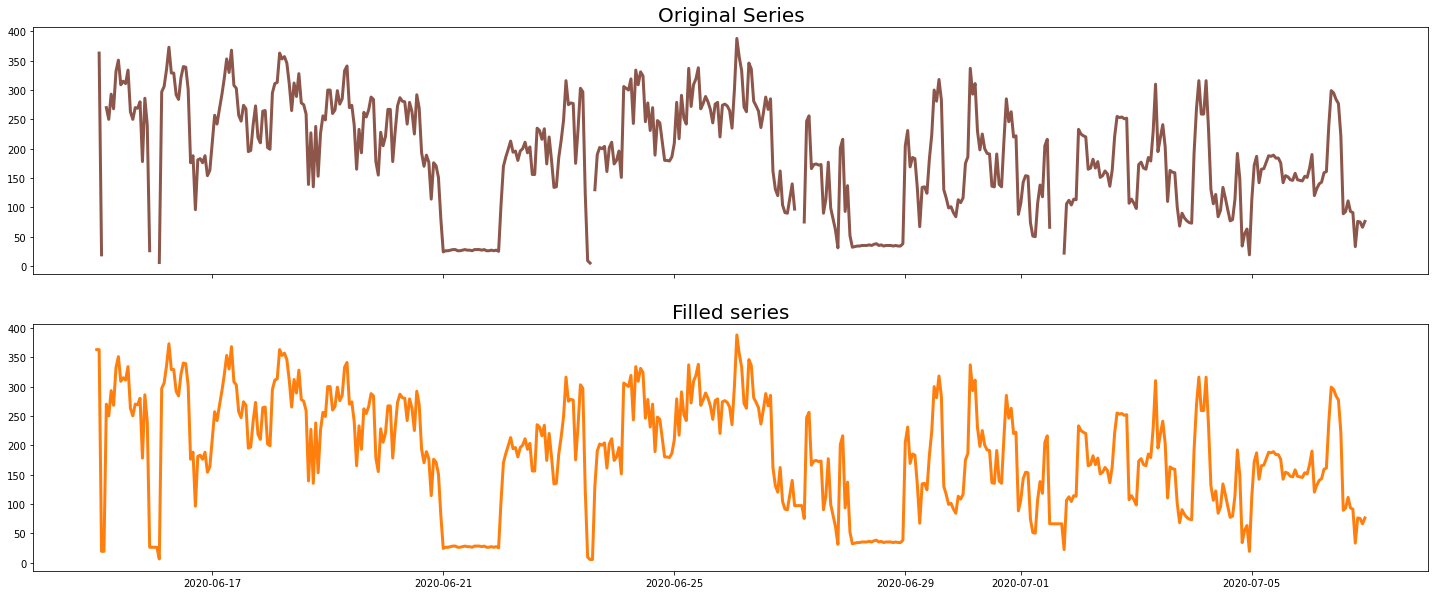

In [21]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,10))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(EM4_filled.index, EM4_filled['EM4'], 'tab:orange', linewidth = 3)
axs[1].set_title('Filled series', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [22]:
data1 = EM4_filled.copy()

In [27]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
df = pd.DataFrame()
window=30
offset=1
n = window-1
l = []
m=0
for i in range(0,len(data1)-n, window):
    train = data1.iloc[i:(window+i)]
    test = data1.iloc[(window+i-1):(window+i+offset)]
    y_hat_avg = test.copy()
    fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 2, trend='add', seasonal='add').fit()
    y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
    rms6 = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
    l.append(rms6)
    m=i

In [28]:
m

480

In [29]:
mean(l)

22.18682561071378

In [36]:
train = EM4_filled[0:31] 
test = EM4_filled[30:32] 

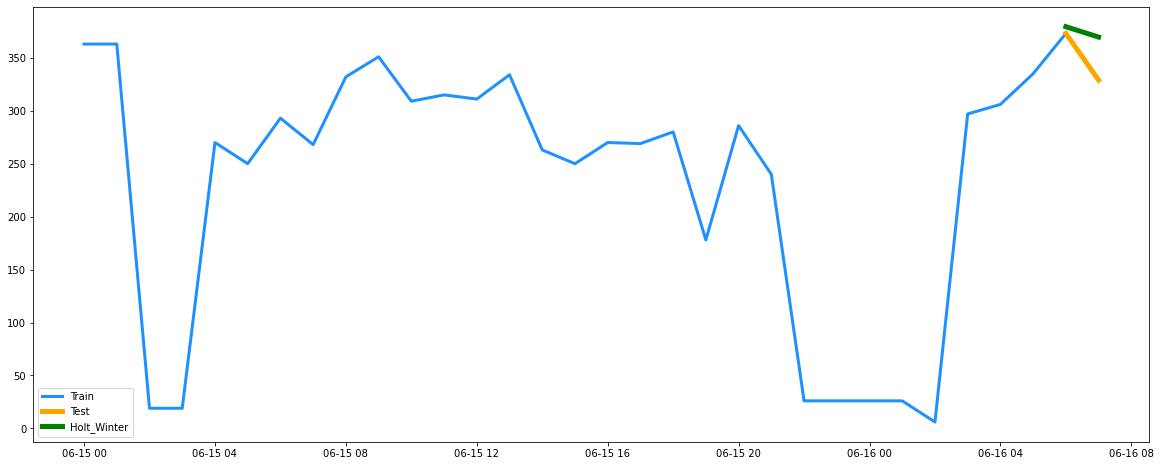

29.071244919516545


In [38]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 2, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
rms6 = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train', lw = 3,color='dodgerblue')
plt.plot(test['EM4'], label='Test', lw = 5,color='orange')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', lw = 5,color='green')
plt.legend(loc='best')
plt.show()  
print(rms6)

In [40]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [41]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [42]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

NameError: name 'ads' is not defined

In [43]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);